In [1]:
import numpy as np
import pandas as pd
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, ELU, Reshape, Concatenate, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import Adam
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

Using TensorFlow backend.
/root/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
from moviepy.editor import VideoFileClip

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [4]:
def ssd_small_model(image_shape, n_classes, l2_reg=0.0, 
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]]):
    n_predictor_layers = 4 # The number of predictor conv layers in the network
    n_classes += 1 # Account for the background class.
    # one box per aspect ratio, so for a predictor layer with 3 ratios then 3 boxes
    n_boxes = []
    scales = [0.08, 0.16, 0.32, 0.64, 0.96] # for anchor boxes 
    variances = np.array([1.0, 1.0, 1.0, 1.0])
    steps = [None] * n_predictor_layers
    offsets = [None] * n_predictor_layers
    
    for i in aspect_ratios_per_layer:
        n_boxes.append(len(i))
    
    img_height, img_width, img_channels = image_shape[0], image_shape[1], image_shape[2]
    x = Input(shape=image_shape)
    x1 = Lambda(lambda x: x - np.array(127.5), output_shape=(img_height, img_width, img_channels),
                   name='input_mean_norm')(x)
    x1 = Lambda(lambda x: x/np.array(127.5), output_shape=(img_height, img_width, img_channels),
                   name='input_scaler')(x1)
    
    #mini base network
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='conv1')(x1)
    conv1 = BatchNormalization(name='bn1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1')(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='conv2')(pool1)
    conv2 = BatchNormalization(name='bn2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2')(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='conv3')(pool2)
    conv3 = BatchNormalization(name='bn3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3')(conv3)
    
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='conv4')(pool3)
    conv4 = BatchNormalization(name='bn4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4')(conv4)
    
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='conv5')(pool4)
    conv5 = BatchNormalization(name='bn5')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool5')(conv5)
    
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='conv6')(pool5)
    conv6 = BatchNormalization(name='bn6')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool')(conv6)
    
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='conv7')(pool6)
    conv7 = BatchNormalization(name='bn7')(conv7)

    #predictor layers for classes and boxes
    
    classes4 = Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='classes4')(conv4)
    classes5 = Conv2D(n_boxes[1] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='classes5')(conv5)
    classes6 = Conv2D(n_boxes[2] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='classes6')(conv6)
    classes7 = Conv2D(n_boxes[3] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='classes7')(conv7)
    
    # 4 coords per box -- xmin, xmax, ymun, ymax
    box4 = Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='box4')(conv4)
    box5 = Conv2D(n_boxes[1] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='box5')(conv5)
    box6 = Conv2D(n_boxes[2] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='box6')(conv6)
    box7 = Conv2D(n_boxes[3] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), name='box7')(conv7)
    
    #use the custom anchorbox layer to generate predictions for boxes
    anchors4 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios_per_layer[0],
                           two_boxes_for_ar1=False, this_steps=steps[0], this_offsets=offsets[0],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors4')(box4)
    anchors5 = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios_per_layer[1],
                           two_boxes_for_ar1=False, this_steps=steps[1], this_offsets=offsets[1],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors5')(box5)
    anchors6 = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios_per_layer[2],
                           two_boxes_for_ar1=False, this_steps=steps[2], this_offsets=offsets[2],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors6')(box6)
    anchors7 = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios_per_layer[3],
                           two_boxes_for_ar1=False, this_steps=steps[3], this_offsets=offsets[3],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors7')(box7)
    
    
    # Reshape the class predictors tensor into (batch, height * width * n_boxes, n_classes) => the class is now the last variable for predcition
    classes4_reshaped = Reshape((-1, n_classes), name='classes4_reshape')(classes4)
    classes5_reshaped = Reshape((-1, n_classes), name='classes5_reshape')(classes5)
    classes6_reshaped = Reshape((-1, n_classes), name='classes6_reshape')(classes6)
    classes7_reshaped = Reshape((-1, n_classes), name='classes7_reshape')(classes7)
    
    # Reshape the box coords predictions, into tensors of shape (batch, height * width * n_boxes, 4) => box positions last for loss
    # We want the four box coordinates isolated in the last axis to compute the smooth L1 loss
    boxes4_reshaped = Reshape((-1, 4), name='boxes4_reshape')(box4)
    boxes5_reshaped = Reshape((-1, 4), name='boxes5_reshape')(box5)
    boxes6_reshaped = Reshape((-1, 4), name='boxes6_reshape')(box6)
    boxes7_reshaped = Reshape((-1, 4), name='boxes7_reshape')(box7)
    # Reshape the anchor box tensors, into tensors of shape (batch, height * width * n_boxes, 8)
    anchors4_reshaped = Reshape((-1, 8), name='anchors4_reshape')(anchors4)
    anchors5_reshaped = Reshape((-1, 8), name='anchors5_reshape')(anchors5)
    anchors6_reshaped = Reshape((-1, 8), name='anchors6_reshape')(anchors6)
    anchors7_reshaped = Reshape((-1, 8), name='anchors7_reshape')(anchors7)
    #concat along the middle axis, since want to keep the batch and n_classes/8 untouched
    class_concat = Concatenate(axis=1, name='concatenate_classes')([classes4_reshaped, 
                                classes5_reshaped,classes6_reshaped, 
                                classes7_reshaped])
    boxes_concat = Concatenate(axis=1, name='concatenate_boxes')([boxes4_reshaped,
                                                             boxes5_reshaped,
                                                             boxes6_reshaped,
                                                             boxes7_reshaped])

    # Output shape of `anchors_final`: (batch, n_boxes_total, 8)
    anchors_concat = Concatenate(axis=1, name='concatenate_anchors')([anchors4_reshaped,
                                                                 anchors5_reshaped,
                                                                 anchors6_reshaped,
                                                                 anchors7_reshaped])
    
    classification_softmax = Activation('softmax', name='classes_softamx')(class_concat)
    
    prediction = Concatenate(axis=2,name='concatenate_output')([classification_softmax,
                                                              boxes_concat,
                                                              anchors_concat ])
    
    model = Model(inputs=x, outputs=prediction)
    
    return model
    
    


In [6]:
import glob

In [24]:
udacity_img = glob.glob('udacity_driving_datasets/*.jpg')
udacity_img = [x.split('/')[1] for x in udacity_img]
udacity_img = shuffle(udacity_img)
train_imsg = udacity_img[:int(len(udacity_img) * 0.8)]
val_imgs = udacity_img[int(len(udacity_img) * 0.8):]

In [25]:
len(train_imsg)

17792

In [14]:
labels = pd.read_csv('udacity_driving_datasets/labels.csv')

In [15]:
labels.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [37]:
labels['class_id'].unique()

array([1, 3, 2, 5, 4])

In [30]:
df_train = labels[labels['frame'].isin(train_imsg)]

In [31]:
df_val = labels[labels['frame'].isin(val_imgs)]

In [32]:
df_train.to_csv('udacity_driving_datasets/train_labels.csv', index=False)

In [33]:
df_val.to_csv('udacity_driving_datasets/val_labels.csv', index=False)

In [5]:
train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])
val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])

# Training dataset
train_images_dir      = 'udacity_driving_datasets/'
train_labels_filename = 'udacity_driving_datasets/train_labels.csv'

# Validation dataset
val_images_dir      = 'udacity_driving_datasets/'
val_labels_filename = 'udacity_driving_datasets/val_labels.csv'

train_dataset.parse_csv(images_dir=train_images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=val_images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

In [6]:
K.clear_session() # Clear previous models from memory.

model = ssd_small_model((300, 480, 3), 5, l2_reg=0.0, 
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]])

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

# with negative hard mining as per paper
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [57]:
model.get_layer('classes4').output_shape

(None, 60, 38, 18)

In [84]:
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_box_encoder = SSDBoxEncoder(img_height=300,
                                img_width=480,
                                n_classes=5, 
                                predictor_sizes=predictor_sizes,
                                scales=[0.08, 0.16, 0.32, 0.64, 0.96],
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                                two_boxes_for_ar1=False,
                                steps=None,
                                offsets=None,
                                limit_boxes=False,
                                variances=[1.,1.,1.,1.],
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords='centroids',
                                normalize_coords=True)

# 4: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into memory issues with your GPU.

# 5: Set the image processing / data augmentation options and create generator handles.

# Change the online data augmentation settings as you like
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5), # Randomly change brightness between 0.5 and 2 with probability 0.5
                                         flip=0.5, # Randomly flip horizontally with probability 0.5
                                         translate=((5, 50), (3, 30), 0.5), # Randomly translate by 5-50 pixels horizontally and 3-30 pixels vertically with probability 0.5
                                         scale=(0.75, 1.3, 0.5), # Randomly scale between 0.75 and 1.3 with probability 0.5
                                         max_crop_and_resize=False,
                                         random_pad_and_resize=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=True,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=False,
                                     random_pad_and_resize=False,
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4)

# Get the number of samples in the training and validations datasets to compute the epoch lengths below.
n_train_samples = train_dataset.get_n_samples()
n_val_samples = val_dataset.get_n_samples()

In [85]:
epochs = 10

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = (n_train_samples//batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('ssd7_train/ssd7_weights_epoch-{epoch:02d}_loss-{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=2),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)],
                              validation_data = val_generator,
                              validation_steps = (n_val_samples//batch_size))

# TODO: Set the filename (without the .h5 file extension!) under which to save the model and weights.
#       Do the same in the `ModelCheckpoint` callback above.
model_name = 'ssd7'
model.save('ssd7_train/{}.h5'.format(model_name))
model.save_weights('ssd7_train/{}_weights.h5'.format(model_name))

print()
print("Model saved under ssd7_train/{}.h5".format(model_name))
print("Weights also saved separately under ssd7_train/{}_weights.h5".format(model_name))
print()

Epoch 1/10
556/556 [==============================] - 520s 935ms/step - loss: 4.9830 - val_loss: 2.9792
Epoch 2/10
556/556 [==============================] - 517s 930ms/step - loss: 2.5359 - val_loss: 2.5140
Epoch 3/10
556/556 [==============================] - 518s 931ms/step - loss: 2.1847 - val_loss: 2.1772
Epoch 4/10
556/556 [==============================] - 517s 930ms/step - loss: 2.0181 - val_loss: 2.0614
Epoch 5/10
556/556 [==============================] - 516s 928ms/step - loss: 1.9109 - val_loss: 1.8457
Epoch 6/10
556/556 [==============================] - 516s 929ms/step - loss: 1.8348 - val_loss: 1.8023
Epoch 7/10
556/556 [==============================] - 516s 928ms/step - loss: 1.7661 - val_loss: 1.9096
Epoch 8/10
556/556 [==============================] - 517s 930ms/step - loss: 1.6880 - val_loss: 1.6977
Epoch 9/10
556/556 [==============================] - 517s 930ms/step - loss: 1.6508 - val_loss: 1.6393
Epoch 10/10
556/556 [==============================] - 518s 931m

In [14]:
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         train=False,
                                         returns={'processed_labels',
                                                  'filenames'},
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         max_crop_and_resize=False,
                                         random_pad_and_resize=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4)

In [87]:
X, y_true, filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

Image: udacity_driving_datasets/1479503055782695170.jpg

Ground truth boxes:

[[  1 112 131 142 146]
 [  1 165 119 310 233]
 [  3   9 130  18 154]
 [  3 281 130 289 138]
 [  3 288 131 296 148]
 [  3 298 130 306 152]]


In [88]:
y_pred = model.predict(X)

In [89]:
y_pred

array([[[ 0.98,  0.  ,  0.  , ...,  1.  ,  1.  ,  1.  ],
        [ 0.97,  0.01,  0.  , ...,  1.  ,  1.  ,  1.  ],
        [ 0.98,  0.  ,  0.  , ...,  1.  ,  1.  ,  1.  ],
        ..., 
        [ 0.99,  0.  ,  0.  , ...,  1.  ,  1.  ,  1.  ],
        [ 1.  ,  0.  ,  0.  , ...,  1.  ,  1.  ,  1.  ],
        [ 0.99,  0.  ,  0.  , ...,  1.  ,  1.  ,  1.  ]]], dtype=float32)

In [90]:
y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.1,
                           iou_threshold=0.2,
                           top_k='all',
                           input_coords='centroids',
                           normalize_coords=False,
                           img_height=300,
                           img_width=480)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Decoded predictions (output format is [class_id, confidence, xmin, ymin, xmax, ymax]):\n")
print(y_pred_decoded[i])

Decoded predictions (output format is [class_id, confidence, xmin, ymin, xmax, ymax]):

[[   1.      0.99  169.93  117.46  323.6   234.2 ]]


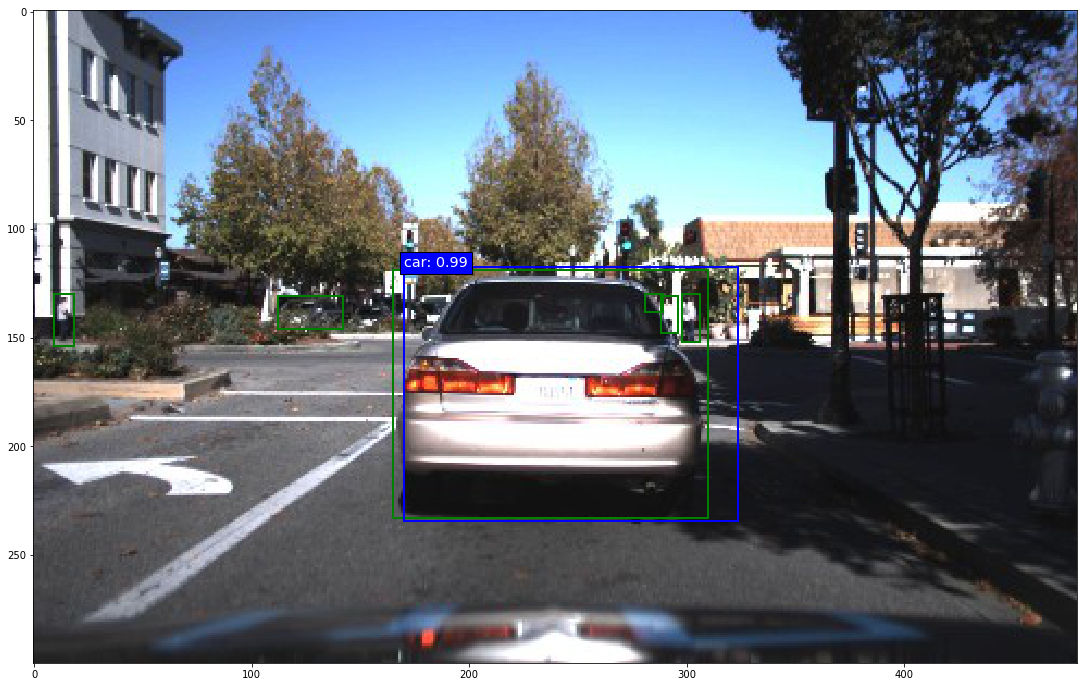

In [92]:
plt.figure(figsize=(20,12))
plt.imshow(X[i])

current_axis = plt.gca()

classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in y_true[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
#     color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

In [93]:
epochs = 20

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = (n_train_samples//batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('ssd7_train/ssd7_weights_epoch2-{epoch:02d}_loss-{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=2),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)],
                              validation_data = val_generator,
                              validation_steps = (n_val_samples//batch_size))

# TODO: Set the filename (without the .h5 file extension!) under which to save the model and weights.
#       Do the same in the `ModelCheckpoint` callback above.
model_name = 'ssd7_2'
model.save('ssd7_train/{}.h5'.format(model_name))
model.save_weights('ssd7_train/{}_weights.h5'.format(model_name))

print()
print("Model saved under ssd7_train/{}.h5".format(model_name))
print("Weights also saved separately under ssd7_train/{}_weights.h5".format(model_name))
print()

Epoch 1/20
556/556 [==============================] - 519s 933ms/step - loss: 1.5947 - val_loss: 1.5493
Epoch 2/20
556/556 [==============================] - 515s 926ms/step - loss: 1.5803 - val_loss: 1.5482
Epoch 3/20
556/556 [==============================] - 517s 930ms/step - loss: 1.5640 - val_loss: 1.5473
Epoch 4/20
556/556 [==============================] - 516s 928ms/step - loss: 1.5280 - val_loss: 1.4853
Epoch 5/20
556/556 [==============================] - 516s 929ms/step - loss: 1.5196 - val_loss: 1.4712
Epoch 6/20
556/556 [==============================] - 516s 929ms/step - loss: 1.5134 - val_loss: 1.5696
Epoch 7/20
556/556 [==============================] - 519s 933ms/step - loss: 1.4958 - val_loss: 1.4646
Epoch 8/20
556/556 [==============================] - 518s 932ms/step - loss: 1.4937 - val_loss: 1.4533
Epoch 9/20
556/556 [==============================] - 517s 931ms/step - loss: 1.4890 - val_loss: 1.4466
Epoch 10/20
556/556 [==============================] - 517s 931m

In [11]:
trained_ssd7_v1 = load_model('ssd7_train/ssd7.h5', custom_objects={'AnchorBoxes': AnchorBoxes,
                                               #'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

TypeError: List of Tensors when single Tensor expected

In [7]:
model.load_weights('ssd7_train/ssd7_2_weights.h5')

Image: udacity_driving_datasets/1478900992520754357.jpg

Ground truth boxes:

[[  1  95 147 120 170]
 [  1  96 148 121 167]
 [  1 167 147 189 167]
 [  1 183 147 234 186]
 [  1 189 116 236 150]
 [  2 192 120 231 157]
 [  3 273 147 285 165]
 [  5 133 127 142 141]
 [  5 133 127 143 143]
 [  5 206  86 219 106]
 [  5 208  89 217 104]
 [  5 265 121 273 136]
 [  5 318  77 336  99]
 [  5 322  76 335 102]]
Decoded predictions (output format is [class_id, confidence, xmin, ymin, xmax, ymax]):

[[   1.      1.    178.61  146.96  237.31  187.32]
 [   1.      0.99   94.54  148.    121.8   166.93]
 [   1.      0.99  167.15  146.71  191.49  167.92]
 [   5.      0.55  138.13  124.53  143.25  138.1 ]]


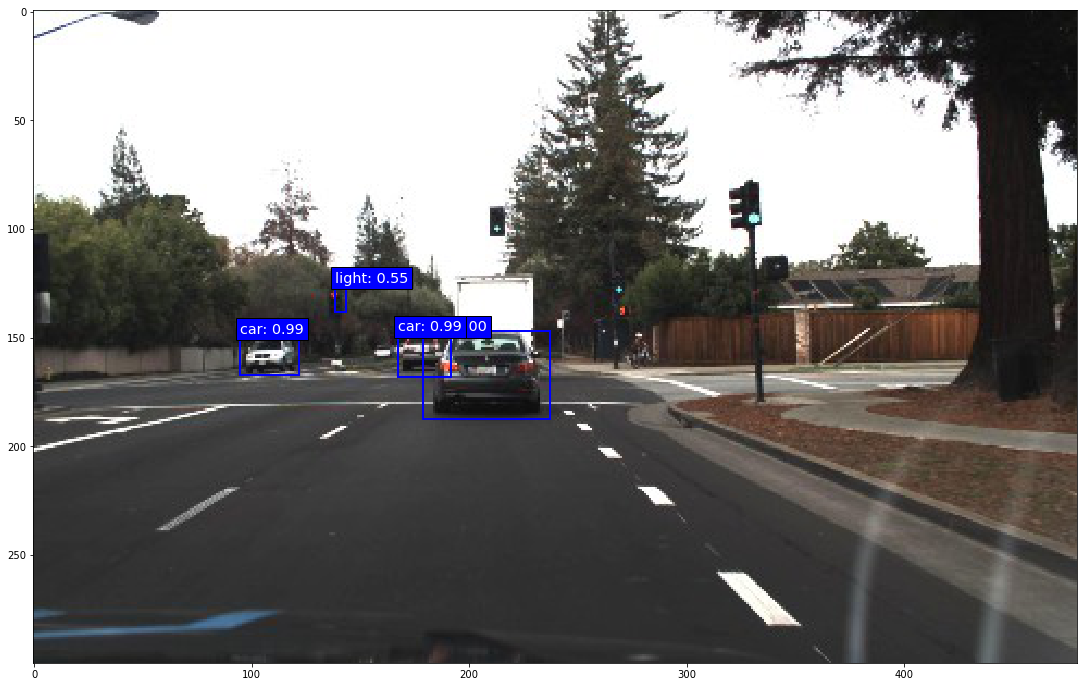

In [30]:
X, y_true, filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

y_pred = model.predict(X)
def plot_decoded(y_predicted, inputImg):
    y_pred_decoded = decode_y2(y_predicted,
                               confidence_thresh=0.1,
                               iou_threshold=0.2,
                               top_k='all',
                               input_coords='centroids',
                               normalize_coords=False,
                               img_height=300,
                               img_width=480)

    np.set_printoptions(precision=2, suppress=True, linewidth=90)
    print("Decoded predictions (output format is [class_id, confidence, xmin, ymin, xmax, ymax]):\n")
    print(y_pred_decoded[i])

    plt.figure(figsize=(20,12))
    plt.imshow(inputImg)

    current_axis = plt.gca()

    classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

    # Draw the ground truth boxes in green (omit the label for more clarity)
#     for box in y_true[i]:
#         xmin = box[1]
#         ymin = box[2]
#         xmax = box[3]
#         ymax = box[4]
#         label = '{}'.format(classes[int(box[0])])
#         current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
        #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

    # Draw the predicted boxes in blue
    for box in y_pred_decoded[i]:
        xmin = box[-4]
        ymin = box[-3]
        xmax = box[-2]
        ymax = box[-1]
    #     color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})
plot_decoded(y_pred, X[i])

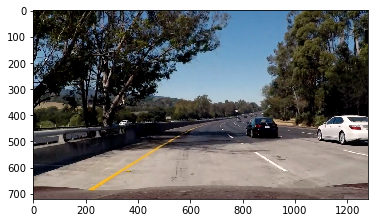

In [20]:
test_image = cv2.cvtColor(cv2.imread('test_images/test5.jpg'), cv2.COLOR_RGB2BGR)
plt.imshow(test_image)

In [21]:
inputImg = cv2.resize(test_image, (480, 300))

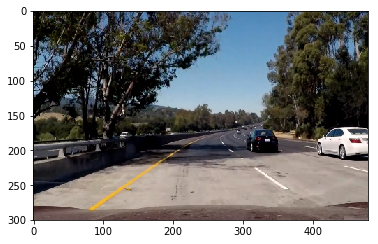

In [22]:
plt.imshow(inputImg)

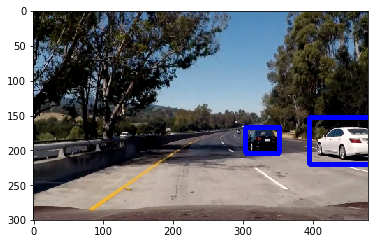

In [28]:
y_pred_test = model.predict(np.array([inputImg]))
plt.imshow(draw_decoded(y_pred_test, inputImg))

In [27]:
def draw_decoded(y_predicted, inputImg):
    y_pred_decoded = decode_y2(y_predicted,
                               confidence_thresh=0.4,
                               iou_threshold=0.1,
                               top_k='all',
                               input_coords='centroids',
                               normalize_coords=False,
                               img_height=300,
                               img_width=480)
    #udacity traffic dataset classes
    classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] 
    image = np.copy(inputImg)
    # Draw the predicted boxes in blue:
    #Decoded predictions of boxes (is a list of [class_id, confidence, xmin, ymin, xmax, ymax])
    for box in y_pred_decoded[0]:
        if(box[0] == 1 or box[0] ==2):
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
            xmin = box[2] * image.shape[1] / 480
            ymin = box[3] * (image.shape[0]) / 300
            xmax = box[4] * image.shape[1] / 480
            ymax = box[5] * (image.shape[0] )/ 300


            cv2.rectangle(image, (np.int(xmin), np.int(ymin) ), (np.int(xmax),np.int(ymax )), (0, 0, 255), 6)
    
    return image

In [18]:
plt.imshow(draw_decoded(y_pred_test, test_image))

NameError: name 'y_pred_test' is not defined

In [29]:
def pipeline(image):
    
    img_input = cv2.resize(image, (480, 300))

    predict = model.predict(np.array([img_input]))

    image_out = draw_decoded(predict, image)
    return image_out

In [30]:
video_output = 'ssd7_output_test_c-04-i-01.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip_out = clip1.fl_image(pipeline)
%time clip_out.write_videofile(video_output, audio=False, progress_bar=False, verbose=False)

CPU times: user 5min 47s, sys: 20.4 s, total: 6min 7s
Wall time: 2min 21s


In [15]:
frames = int(clip1.fps * clip1.duration)

In [16]:
fps = frames/timer
print('frames per second:', fps)

frames per second: 14.71946177797356


In [ ]:
# 85s for 